In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Preprocessing - Training and testing split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Exploratory Data Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV 
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge

#Evaluation: 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
# It looks like ir is not available any more!
# from sklearn.metrics import mean_absolute_percentage_error

In [234]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

## Loading Training/Testing Data:

In [235]:
train_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/train.csv'
test_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/test.csv'

train_df = pd.read_csv(train_url, low_memory=False, error_bad_lines=False, index_col='Id')
test_df = pd.read_csv(test_url, low_memory=False, error_bad_lines=False, index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [236]:
# This is for checking datatypes
# train_df.info()
# test_df.info()

## Data Preprocessing:

## Missing Data Imputation

In [237]:
def missing_cnt_percent(df):
    # create df that consists of columns and the number of missing values for each 
    data = df.isnull().sum().sort_values(ascending=False)
    missing_df = pd.DataFrame(data=data, columns=['missing_cnt'])

    # add column and fill it with the percentage of those missing values
    missing_df['percent_missing'] = missing_df.missing_cnt.apply(lambda x : '{:.2f}'.format(x/df.shape[0] * 100)) 
    missing_df = missing_df[missing_df.missing_cnt > 0]
    print(missing_df)

In [238]:
missing_cnt_percent(train_df)

              missing_cnt percent_missing
PoolQC               1453           99.52
MiscFeature          1406           96.30
Alley                1369           93.77
Fence                1179           80.75
FireplaceQu           690           47.26
LotFrontage           259           17.74
GarageType             81            5.55
GarageCond             81            5.55
GarageFinish           81            5.55
GarageQual             81            5.55
GarageYrBlt            81            5.55
BsmtFinType2           38            2.60
BsmtExposure           38            2.60
BsmtQual               37            2.53
BsmtCond               37            2.53
BsmtFinType1           37            2.53
MasVnrArea              8            0.55
MasVnrType              8            0.55
Electrical              1            0.07


In [239]:
# These columns has NA value that is different from null(NaN)!
train_df.update(train_df[['PoolQC']].fillna('NA'))
train_df.update(train_df[['MiscFeature']].fillna('NA'))
train_df.update(train_df[['Alley']].fillna('NA'))
train_df.update(train_df[['Fence']].fillna('NA'))
train_df.update(train_df[['FireplaceQu']].fillna('NA'))

In [240]:
# All 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond' columns has 1379 not null values!
# So, I tested the theory that exactly same rows has null for these columns!
# All 81 do not have Garage! So, we can put zero/'NA' instead!
train_df.loc[:,['GarageCars','GarageArea','GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond']][train_df['GarageType'].isnull()]


,GarageCars,GarageArea,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond
Id,,,,,,,,
40,0,0,NaN,NaN,NaN,0,NaN,NaN
49,0,0,NaN,NaN,NaN,0,NaN,NaN
79,0,0,NaN,NaN,NaN,0,NaN,NaN
89,0,0,NaN,NaN,NaN,0,NaN,NaN
90,0,0,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...
1350,0,0,NaN,NaN,NaN,0,NaN,NaN
1408,0,0,NaN,NaN,NaN,0,NaN,NaN
1450,0,0,NaN,NaN,NaN,0,NaN,NaN


In [241]:
# All 81 do not have Garage! So, we can put zero/'NA' instead!
train_df.update(train_df[['GarageYrBlt','GarageCars']].fillna(0))
train_df.update(train_df[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna('NA'))

In [242]:
# Same for Basement: 'BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1'
train_df.loc[:,['TotalBsmtSF','BsmtUnfSF','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1']][train_df['BsmtCond'].isnull()]

,TotalBsmtSF,BsmtUnfSF,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1
Id,,,,,,,
18,0,0,NaN,NaN,NaN,NaN,NaN
40,0,0,NaN,NaN,NaN,NaN,NaN
91,0,0,NaN,NaN,NaN,NaN,NaN
103,0,0,NaN,NaN,NaN,NaN,NaN
157,0,0,NaN,NaN,NaN,NaN,NaN
183,0,0,NaN,NaN,NaN,NaN,NaN
260,0,0,NaN,NaN,NaN,NaN,NaN
343,0,0,NaN,NaN,NaN,NaN,NaN
363,0,0,NaN,NaN,NaN,NaN,NaN


In [243]:
# All 37 do not have Garage! So, we can put 'NA' instead!
train_df.update(train_df[['BsmtQual','BsmtCond','BsmtFinType1']].fillna('NA'))

In [244]:
# Same for Basement: 'BsmtFinType2','BsmtExposure'
train_df.loc[:,['TotalBsmtSF','BsmtUnfSF','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1']][train_df['BsmtExposure'].isnull()]

,TotalBsmtSF,BsmtUnfSF,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1
Id,,,,,,,
18,0,0,NaN,NaN,NA,NA,NA
40,0,0,NaN,NaN,NA,NA,NA
91,0,0,NaN,NaN,NA,NA,NA
103,0,0,NaN,NaN,NA,NA,NA
157,0,0,NaN,NaN,NA,NA,NA
183,0,0,NaN,NaN,NA,NA,NA
260,0,0,NaN,NaN,NA,NA,NA
343,0,0,NaN,NaN,NA,NA,NA
363,0,0,NaN,NaN,NA,NA,NA


In [245]:
train_df.at[949,'BsmtExposure']='No'

In [246]:
train_df.loc[:,['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1']][train_df['BsmtFinType2'].isnull()]

,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1
Id,,,,,,,,
18,0,0,0,NaN,NaN,NA,NA,NA
40,0,0,0,NaN,NaN,NA,NA,NA
91,0,0,0,NaN,NaN,NA,NA,NA
103,0,0,0,NaN,NaN,NA,NA,NA
157,0,0,0,NaN,NaN,NA,NA,NA
183,0,0,0,NaN,NaN,NA,NA,NA
260,0,0,0,NaN,NaN,NA,NA,NA
333,3206,1603,479,NaN,No,Gd,TA,GLQ
343,0,0,0,NaN,NaN,NA,NA,NA


In [247]:
# I'm going with 'Average Living Quarters'
train_df.at[333,'BsmtFinType2']='ALQ'
train_df.update(train_df[['BsmtFinType2','BsmtExposure']].fillna('NA'))

In [248]:
train_df.update(train_df[['Electrical']].fillna('SBrkr'))

In [249]:
#I'm not professional but I think there is no Masonry veneer type for the Vinyl and Cement!
train_df.at[530,'MasVnrType']='Stone'

# train_df['Set_of_Numbers'] = train_df['Set_of_Numbers'].fillna(0)
train_df.update(train_df[['MasVnrArea']].fillna(0))
train_df.update(train_df[['MasVnrType']].fillna('None'))

In [250]:
train_df['LotFrontage'] = train_df['LotFrontage'].fillna((train_df['LotFrontage'].mean()))

In [251]:
missing_cnt_percent(train_df)

Empty DataFrame
Columns: [missing_cnt, percent_missing]
Index: []


## Convert categorical string to numeric

Categorical Variable Analysis for ordered categories

In [252]:
# LotShape
quality_ratings1 = {
    "IR3" : 1,
	"IR2" : 2,
	"IR1" : 3,
	"Reg" : 4
}
train_df["LotShape_Num"] = train_df.LotShape.map(quality_ratings1)
test_df["LotShape_Num"] = test_df.LotShape.map(quality_ratings1)

In [253]:
	# LandContour
quality_ratings2 = {
	"Low" : 1,
	"HLS" : 2,
	"Bnk" : 3,
	"Lvl" : 4
}
train_df["LandContour_Num"] = train_df.LandContour.map(quality_ratings2)
test_df["LandContour_Num"] = test_df.LandContour.map(quality_ratings2)

In [254]:
	# LandSlope
quality_ratings3 = {
	"Sev" : 1,
	"Mod" : 2,
	"Gtl" : 3
}
train_df["LandSlope_Num"] = train_df.LandSlope.map(quality_ratings3)
test_df["LandSlope_Num"] = test_df.LandSlope.map(quality_ratings3)

In [255]:
	# ExterQual, ExterCond, HeatingQC, KitchenQual
quality_ratings4 = {
	"Po" : 1,
	"Fa" : 2,
	"TA" : 3,
	"Gd" : 4,
	"Ex" : 5
}
train_df["ExterQual_Num"] = train_df.ExterQual.map(quality_ratings4)
train_df["ExterCond_Num"] = train_df.ExterCond.map(quality_ratings4)
train_df["HeatingQC_Num"] = train_df.HeatingQC.map(quality_ratings4)
train_df["KitchenQual_Num"] = train_df.KitchenQual.map(quality_ratings4)

test_df["ExterQual_Num"] = test_df.ExterQual.map(quality_ratings4)
test_df["ExterCond_Num"] = test_df.ExterCond.map(quality_ratings4)
test_df["HeatingQC_Num"] = test_df.HeatingQC.map(quality_ratings4)
test_df["KitchenQual_Num"] = test_df.KitchenQual.map(quality_ratings4)

In [256]:
	# BsmtQual, BsmtCond, GarageQual, GarageCond, FireplaceQu
quality_ratings5 = {
	"NA" : 1,
	"Po" : 2,
	"Fa" : 3,
	"TA" : 4,
	"Gd" : 5,
	"Ex" : 6
}
train_df["BsmtQual_Num"] = train_df.BsmtQual.map(quality_ratings5)
train_df["BsmtCond_Num"] = train_df.BsmtCond.map(quality_ratings5)
train_df["GarageQual_Num"] = train_df.GarageQual.map(quality_ratings5)
train_df["GarageCond_Num"] = train_df.GarageCond.map(quality_ratings5)
train_df["FireplaceQu_Num"] = train_df.FireplaceQu.map(quality_ratings5)

test_df["BsmtQual_Num"] = test_df.BsmtQual.map(quality_ratings5)
test_df["BsmtCond_Num"] = test_df.BsmtCond.map(quality_ratings5)
test_df["GarageQual_Num"] = test_df.GarageQual.map(quality_ratings5)
test_df["GarageCond_Num"] = test_df.GarageCond.map(quality_ratings5)
test_df["FireplaceQu_Num"] = test_df.FireplaceQu.map(quality_ratings5)

In [257]:
	# BsmtExposure
quality_ratings7 = {
	"NA" : 1,
	"No" : 2,
	"Mn" : 3,
	"Av" : 4,
	"Gd" : 5
}
train_df["BsmtExposure_Num"] = train_df.BsmtExposure.map(quality_ratings7)
test_df["BsmtExposure_Num"] = test_df.BsmtExposure.map(quality_ratings7)

In [258]:
	# BsmtFinType1, BsmtFinType2
quality_ratings8 = {
	"NA" : 1,
	"Unf" : 2,
	"LwQ" : 3,
	"Rec" : 4,
	"BLQ" : 5,
	"ALQ" : 6,
	"GLQ" : 7
}
train_df["BsmtFinType1_Num"] = train_df.BsmtFinType1.map(quality_ratings8)
train_df["BsmtFinType2_Num"] = train_df.BsmtFinType2.map(quality_ratings8)

test_df["BsmtFinType1_Num"] = test_df.BsmtFinType1.map(quality_ratings8)
test_df["BsmtFinType2_Num"] = test_df.BsmtFinType2.map(quality_ratings8)

In [259]:
	# Functional
quality_ratings9 = {
	"Sal" : 1,
	"Sev" : 2,
	"Maj2" : 3,
	"Maj1" : 4,
	"Mod" : 5,
	"Min2" : 6,
	"Min1" : 7,
	"Typ" : 8
}
train_df["Functional_Num"] = train_df.Functional.map(quality_ratings9)

test_df["Functional_Num"] = test_df.Functional.map(quality_ratings9)

In [260]:
	# GarageFinish
quality_ratings10 = {
	"NA" : 1,
	"Unf" : 2,
	"RFn" : 3,
	"Fin" : 4
}
train_df["GarageFinish_Num"] = train_df.GarageFinish.map(quality_ratings10)

test_df["GarageFinish_Num"] = test_df.GarageFinish.map(quality_ratings10)

In [261]:
	# CentralAir
quality_ratings11 = {
	"N" : 1,
	"Y" : 2
}
train_df["CentralAir_Num"] = train_df.CentralAir.map(quality_ratings11)

test_df["CentralAir_Num"] = test_df.CentralAir.map(quality_ratings11)

In [262]:
	# PavedDrive
quality_ratings12 = {
	"N" : 1,
	"P" : 2,
	"Y" : 3
}
train_df["PavedDrive_Num"] = train_df.PavedDrive.map(quality_ratings12)

test_df["PavedDrive_Num"] = test_df.PavedDrive.map(quality_ratings12)

In [263]:
	# PoolQC
quality_ratings6 = {
	"NA" : 1,
	"Fa" : 2,
	"TA" : 3,
	"Gd" : 4,
	"Ex" : 5
}
train_df["PoolQC_Num"] = train_df.PoolQC.map(quality_ratings6)
test_df["PoolQC_Num"] = test_df.PoolQC.map(quality_ratings6)

In [264]:
	# MSSubClass
quality_ratings7 = {
    20:"St46nNAS", 
    30:"St45nOl", 
    40:"StwFinAAA", 
    45:"HalfStUnfinAAA", 
    50:"HalfStFinAA",
    60:"St46nN", 
    70:"St45nOl", 
    75:"HalfStAA", 
    80:"SplorML", 
    85:"SplFoy", 
    90:"DupASnA", 
    120:"StPud46nN", 
    150:"HalfStPudAA", 
    160:"StPud46nNN", 
    180:"PudML", 190:"FamConv"
}
train_df["MSSubClass_Cat"] = train_df.MSSubClass.map(quality_ratings7)
test_df["MSSubClass_Cat"] = test_df.MSSubClass.map(quality_ratings7)

In [265]:
# drop the columns where we replaced with numbers
drop_cols = ['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual','GarageQual','LotShape','LandContour','LandSlope','ExterCond','BsmtCond','GarageCond','FireplaceQu','BsmtExposure','BsmtFinType1','BsmtFinType2','Functional','GarageFinish','CentralAir','PavedDrive','PoolQC','MSSubClass']

for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

## Exploratory Data Analysis (EDA)

- Correlation 

In [266]:
corr_matrix = train_df.corr()
corr_matrix['SalePrice'] = round(corr_matrix['SalePrice'],4)
print_full(corr_matrix['SalePrice'].sort_values(ascending=False))

SalePrice           1.0000
OverallQual         0.7910
GrLivArea           0.7086
ExterQual_Num       0.6826
KitchenQual_Num     0.6596
GarageCars          0.6404
GarageArea          0.6234
TotalBsmtSF         0.6136
1stFlrSF            0.6059
BsmtQual_Num        0.5852
FullBath            0.5607
GarageFinish_Num    0.5492
TotRmsAbvGrd        0.5337
YearBuilt           0.5229
FireplaceQu_Num     0.5204
YearRemodAdd        0.5071
MasVnrArea          0.4726
Fireplaces          0.4669
HeatingQC_Num       0.4276
BsmtFinSF1          0.3864
BsmtExposure_Num    0.3750
LotFrontage         0.3349
WoodDeckSF          0.3244
2ndFlrSF            0.3193
OpenPorchSF         0.3159
BsmtFinType1_Num    0.3049
HalfBath            0.2841
GarageQual_Num      0.2738
LotArea             0.2638
GarageCond_Num      0.2632
GarageYrBlt         0.2614
CentralAir_Num      0.2513
PavedDrive_Num      0.2314
BsmtFullBath        0.2271
BsmtUnfSF           0.2145
BsmtCond_Num        0.2126
BedroomAbvGr        0.1682
P

In [267]:
corr_matrix[(corr_matrix.SalePrice<0.3) & (corr_matrix.SalePrice>-0.3)].SalePrice.sort_values(ascending=False)

HalfBath            0.2841
GarageQual_Num      0.2738
LotArea             0.2638
GarageCond_Num      0.2632
GarageYrBlt         0.2614
CentralAir_Num      0.2513
PavedDrive_Num      0.2314
BsmtFullBath        0.2271
BsmtUnfSF           0.2145
BsmtCond_Num        0.2126
BedroomAbvGr        0.1682
PoolQC_Num          0.1155
ScreenPorch         0.1114
Functional_Num      0.1076
PoolArea            0.0924
MoSold              0.0464
3SsnPorch           0.0446
ExterCond_Num       0.0189
BsmtFinType2_Num   -0.0003
BsmtFinSF2         -0.0114
BsmtHalfBath       -0.0168
MiscVal            -0.0212
LowQualFinSF       -0.0256
YrSold             -0.0289
LandSlope_Num      -0.0512
LandContour_Num    -0.0730
OverallCond        -0.0779
EnclosedPorch      -0.1286
KitchenAbvGr       -0.1359
LotShape_Num       -0.2678
Name: SalePrice, dtype: float64

In [268]:
train_df['TotSF_Factor'] = train_df['1stFlrSF']+train_df['2ndFlrSF']+train_df['TotalBsmtSF']
train_df["AddedArea_Factor"] = train_df["GrLivArea"] + train_df["GarageArea"]
train_df["TotBath_Factor"] = train_df["FullBath"] + (train_df["HalfBath"]*0.5)
train_df['Overall_Factor'] = train_df['OverallQual'] * train_df['OverallCond'] * train_df['YearBuilt']
train_df['Yr_Factor'] = train_df['YrSold'] - np.maximum(train_df['YearBuilt'],train_df['YearRemodAdd'])
train_df['Pool_Factor'] = train_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_df['OpenOR3SsnPorch_Factor'] = train_df["OpenPorchSF"].apply(lambda x: 1 if x > 0 else 0) + train_df["3SsnPorch"].apply(lambda x: 1 if x > 0 else 0) + train_df["WoodDeckSF"].apply(lambda x: 1 if x > 0 else 0)
train_df['Kitchen2Flr_Ratio'] = train_df['KitchenAbvGr'] / (train_df['1stFlrSF'].apply(lambda x: 1 if x > 0 else 0) + train_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) + train_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0))

## Not high corr
# train_df['BathPerBedRoom_Factor'] = train_df['FullBath'] / (train_df['BedroomAbvGr']+0.01)
# train_df['BsmtFin2TotBsmtSF_Ratio'] = (train_df['BsmtFinSF1']+train_df['BsmtFinSF2']) / (train_df['TotalBsmtSF']+0.01)
# train_df["Age_factor"] = train_df["YearRemodAdd"] - train_df["YearBuilt"]
# train_df['Options_Factor'] =train_df['Porch_Factor'] + train_df['BathPerRoom_Factor'] + train_df['Pool_Factor']  + train_df["Bsmt_factor"]
# train_df['GarageCars2Area_Ratio'] = train_df['GarageCars'] / (train_df['GarageArea']+0.01)
# train_df['Porch_Factor'] = (train_df['OpenPorchSF'] + train_df['EnclosedPorch']+ train_df['3SsnPorch']+ train_df['ScreenPorch']+0.01)
# train_df['2ndFlr_Factor'] = train_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# train_df["Bsmt_factor"] = train_df["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
# train_df['TotGrLiv2Lot_Ratio'] = train_df['GrLivArea'] / (train_df['LotArea']+0.01)
# train_df['TotSF2Lot_Ratio'] = (train_df['1stFlrSF']+train_df['2ndFlrSF']+train_df['TotalBsmtSF']) / (train_df['LotArea']+0.01)
# train_df['TotBsmtBath2BsmtSF_Ratio'] = (train_df['BsmtFullBath'] + train_df['BsmtHalfBath'])/(train_df['TotalBsmtSF']+0.01)
# train_df['ClosePorch_Factor'] = train_df['ScreenPorch'] + train_df['EnclosedPorch']
# train_df['LowQualFin2TotSF_Ratio'] = train_df['LowQualFinSF'] / (train_df['1stFlrSF']+train_df['2ndFlrSF']+train_df['TotalBsmtSF']+0.01)

In [269]:
test_df['TotSF_Factor'] = test_df['1stFlrSF']+test_df['2ndFlrSF']+test_df['TotalBsmtSF']
test_df["AddedArea_Factor"] = test_df["GrLivArea"] + test_df["GarageArea"]
test_df["TotBath_Factor"] = test_df["FullBath"] + (test_df["HalfBath"]*0.5)
test_df['Overall_Factor'] = test_df['OverallQual'] * test_df['OverallCond'] * test_df['YearBuilt']
test_df['Yr_Factor'] = test_df['YrSold'] - np.maximum(test_df['YearBuilt'],test_df['YearRemodAdd'])
test_df['Pool_Factor'] = test_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test_df['OpenOR3SsnPorch_Factor'] = test_df["OpenPorchSF"].apply(lambda x: 1 if x > 0 else 0) + test_df["3SsnPorch"].apply(lambda x: 1 if x > 0 else 0) + test_df["WoodDeckSF"].apply(lambda x: 1 if x > 0 else 0)
test_df['Kitchen2Flr_Ratio'] = test_df['KitchenAbvGr'] / (test_df['1stFlrSF'].apply(lambda x: 1 if x > 0 else 0) + test_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) + test_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0))


In [270]:
drop_cols = ['HalfBath', 'GarageQual_Num','LotArea','GarageCond_Num', 'GarageYrBlt', 'CentralAir_Num',
             'PavedDrive_Num','BsmtFullBath','BsmtUnfSF','BsmtCond_Num','BedroomAbvGr','ScreenPorch',
             'Street','Utilities','Functional_Num','Pool_Factor','PoolArea','LandContour_Num','OverallCond','EnclosedPorch',
             'MiscFeature','KitchenAbvGr','Kitchen2Flr_Ratio','LotShape_Num','PoolQC_Num']
# drop_cols = ['MoSold','3SsnPorch','ExterCond_Num','BsmtFinType2_Num','BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF','YrSold','Street','Utilities','LandSlope_Num','PoolQC_Num','MiscFeature']
for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

In [271]:
corr_matrix = train_df.corr()
corr_matrix['SalePrice'] = round(corr_matrix['SalePrice'],4)
print_full(corr_matrix['SalePrice'].sort_values(ascending=False))

SalePrice                 1.0000
OverallQual               0.7910
TotSF_Factor              0.7823
AddedArea_Factor          0.7736
GrLivArea                 0.7086
ExterQual_Num             0.6826
KitchenQual_Num           0.6596
GarageCars                0.6404
GarageArea                0.6234
TotalBsmtSF               0.6136
1stFlrSF                  0.6059
TotBath_Factor            0.5980
Overall_Factor            0.5938
BsmtQual_Num              0.5852
FullBath                  0.5607
GarageFinish_Num          0.5492
TotRmsAbvGrd              0.5337
YearBuilt                 0.5229
FireplaceQu_Num           0.5204
YearRemodAdd              0.5071
MasVnrArea                0.4726
OpenOR3SsnPorch_Factor    0.4707
Fireplaces                0.4669
HeatingQC_Num             0.4276
BsmtFinSF1                0.3864
BsmtExposure_Num          0.3750
LotFrontage               0.3349
WoodDeckSF                0.3244
2ndFlrSF                  0.3193
OpenPorchSF               0.3159
BsmtFinTyp

In [272]:
corr_matrix[(corr_matrix.SalePrice<0.3) & (corr_matrix.SalePrice>-0.3)].SalePrice.sort_values(ascending=False)

MoSold              0.0464
3SsnPorch           0.0446
ExterCond_Num       0.0189
BsmtFinType2_Num   -0.0003
BsmtFinSF2         -0.0114
BsmtHalfBath       -0.0168
MiscVal            -0.0212
LowQualFinSF       -0.0256
YrSold             -0.0289
LandSlope_Num      -0.0512
Name: SalePrice, dtype: float64

In [273]:
drop_cols = ['MoSold','3SsnPorch','ExterCond_Num','BsmtFinType2_Num','BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF','YrSold','LandSlope_Num']
# drop_cols = ['KitchenAbvGr','PoolArea','OpenPorchSF','LandContour_Num','EnclosedPorch','ScreenPorch','OverallCond','FullBath','HalfBath']
for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

- Variance Inflation Factor

In [274]:
num_features = [col for col in train_df.columns if train_df[col].dtypes != 'O' and col not in "Id"]
train_df_vif = train_df.loc[:,train_df.columns.isin(num_features)]

In [275]:
X = add_constant(train_df_vif)
print_full(pd.Series([variance_inflation_factor(X.values, i)
          for i in range(X.shape[1])], index=X.columns))

const                     2.373305e+06
LotFrontage               1.326127e+00
OverallQual               6.592150e+00
YearBuilt                 3.999487e+00
YearRemodAdd              2.489281e+02
MasVnrArea                1.402326e+00
BsmtFinSF1                2.801563e+00
TotalBsmtSF                        inf
1stFlrSF                           inf
2ndFlrSF                           inf
GrLivArea                          inf
FullBath                  9.054148e+00
TotRmsAbvGrd              3.509259e+00
Fireplaces                4.552441e+00
GarageCars                5.667381e+00
GarageArea                         inf
WoodDeckSF                1.868005e+00
OpenPorchSF               1.493025e+00
SalePrice                 5.401547e+00
ExterQual_Num             3.077289e+00
HeatingQC_Num             1.664309e+00
KitchenQual_Num           2.700515e+00
BsmtQual_Num              3.074215e+00
FireplaceQu_Num           4.778603e+00
BsmtExposure_Num          1.455961e+00
BsmtFinType1_Num         

In [276]:
drop_cols = ['GrLivArea','2ndFlrSF']
for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

In [277]:
num_features = [col for col in train_df.columns if train_df[col].dtypes != 'O' and col not in "Id"]
train_df_vif = train_df.loc[:,train_df.columns.isin(num_features)]

In [278]:
X = add_constant(train_df_vif)
print_full(pd.Series([variance_inflation_factor(X.values, i)
          for i in range(X.shape[1])], index=X.columns))

const                     2.373305e+06
LotFrontage               1.326127e+00
OverallQual               6.592150e+00
YearBuilt                 3.999487e+00
YearRemodAdd              2.489281e+02
MasVnrArea                1.402326e+00
BsmtFinSF1                2.801563e+00
TotalBsmtSF               9.556304e+01
1stFlrSF                  5.691044e+00
FullBath                  9.054148e+00
TotRmsAbvGrd              3.509259e+00
Fireplaces                4.552441e+00
GarageCars                5.667381e+00
GarageArea                2.713995e+01
WoodDeckSF                1.868005e+00
OpenPorchSF               1.493025e+00
SalePrice                 5.401547e+00
ExterQual_Num             3.077289e+00
HeatingQC_Num             1.664309e+00
KitchenQual_Num           2.700515e+00
BsmtQual_Num              3.074215e+00
FireplaceQu_Num           4.778603e+00
BsmtExposure_Num          1.455961e+00
BsmtFinType1_Num          2.338892e+00
GarageFinish_Num          2.046421e+00
TotSF_Factor             

## Outliers Analysis:

In [279]:
def outlier_thresholds(df, var):
    quartile1 = df[var].quantile(0.05)
    quartile3 = df[var].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def has_outliers(df, num_col_names):
    var_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(df, col)
        if df[(df[col] > up_limit) | (df[col] < low_limit)].any(axis=None):
            number_of_outliers = df[(df[col] > up_limit) | (df[col] < low_limit)].shape[0]
            var_names.append(col)
    return var_names

def replace_with_thresholds(df, var):
    low_limit, up_limit = outlier_thresholds(df, var)
    df.loc[(df[var] < low_limit), var] = low_limit
    df.loc[(df[var] > up_limit), var] = up_limit

In [280]:
has_outliers(train_df, num_features)

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice',
 'TotSF_Factor',
 'AddedArea_Factor']

In [281]:
for col in num_features:
    replace_with_thresholds(train_df, col)

has_outliers(train_df, num_features)

[]

## Categorical Variable Analysis for non-ordered categories

In [282]:
train_df = pd.get_dummies(data = train_df, columns = ["SaleCondition", "MSSubClass_Cat", "MSZoning", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
        "Exterior2nd", "MasVnrType", "Foundation", "Heating", "Electrical", "GarageType", "SaleType", "Fence", "Alley"] , drop_first=True)

In [283]:
train_df.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,Alley_NA,Alley_Pave
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,7.0,2003.0,2003.0,196.0,706.0,856.0,856.0,2.0,8.0,...,0,0,0,1,0,0,0,1,1,0
2,80.0,6.0,1976.0,1976.0,0.0,978.0,1262.0,1262.0,2.0,6.0,...,0,0,0,1,0,0,0,1,1,0
3,68.0,7.0,2001.0,2002.0,162.0,486.0,920.0,920.0,2.0,6.0,...,0,0,0,1,0,0,0,1,1,0
4,60.0,7.0,1915.0,1970.0,0.0,216.0,756.0,961.0,1.0,7.0,...,0,0,0,1,0,0,0,1,1,0
5,84.0,8.0,2000.0,2000.0,350.0,655.0,1145.0,1145.0,2.0,9.0,...,0,0,0,1,0,0,0,1,1,0


In [284]:
test_df = pd.get_dummies(data = test_df, columns = ["SaleCondition", "MSSubClass_Cat", "MSZoning", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
        "Exterior2nd", "MasVnrType", "Foundation", "Heating", "Electrical", "GarageType", "SaleType", "Fence", "Alley"] , drop_first=True)

In [285]:
train_cols = train_df.columns
test_cols = test_df.columns

train_not_test = train_cols.difference(test_cols)
train_not_test

Index(['Alley_NA', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'Fence_NA', 'GarageType_NA', 'Heating_GasA',
       'Heating_OthW', 'HouseStyle_2.5Fin', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'SalePrice'],
      dtype='object')

In [286]:
train_not_test = train_not_test.drop(['SalePrice'])
train_not_test

Index(['Alley_NA', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'Fence_NA', 'GarageType_NA', 'Heating_GasA',
       'Heating_OthW', 'HouseStyle_2.5Fin', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll'],
      dtype='object')

In [287]:
test_df = pd.concat([test_df,pd.DataFrame(
    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],index=test_df.index, columns=train_not_test)], axis=1
)

In [288]:
train_cols = train_df.columns
test_cols = test_df.columns

test_not_train = test_cols.difference(train_cols)
test_not_train

Index(['MSSubClass_Cat_HalfStPudAA'], dtype='object')

In [289]:
train_df['MSSubClass_Cat_HalfStPudAA'] = 0

## Split data set into train dataset and test dataset 

In [290]:
#Independent variable:
x= train_df.loc[:,~train_df.columns.isin(['Id','SalePrice'])]

#dependent variable:
y=train_df.loc[:,'SalePrice']

In [291]:
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.3,random_state=42)

# Standardization 

In [292]:
#Independent variable:
X= train_df.loc[:,~train_df.columns.isin(['Id','SalePrice'])]

#dependent variable:
Y=train_df[['SalePrice']]

In [293]:
sc_X = StandardScaler()
sc_Y = StandardScaler()

In [294]:
X_s = sc_X.fit_transform(X)
Y_s = sc_X.fit_transform(Y)

In [295]:
x_s_train, x_s_test, y_s_train, y_s_test= train_test_split(X_s,Y_s,test_size=0.3,random_state=42)

# Model

In [296]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

## Linear Regression

In [297]:
ln_reg=LinearRegression()

In [298]:
ln_reg.fit(x_train,y_train)

LinearRegression()

In [299]:
ln_y_pred=ln_reg.predict(x_test)

In [300]:
print('MAPE = ', mean_absolute_percentage_error(y_test,ln_y_pred),
      '\nMSE = ', mean_squared_error(y_test,ln_y_pred),
      '\nr2_score = ', r2_score(y_test,ln_y_pred))

MAPE =  12.566541965177866 
MSE =  1217075145.0903237 
r2_score =  0.8210562106335724


## Decision Tree

In [301]:
regressor_dt = DecisionTreeRegressor()
regressor_dt.fit(x_train, y_train)

DecisionTreeRegressor()

In [302]:
dt_y_pred=regressor_dt.predict(x_test)

In [303]:
# mean_absolute_percentage_error(y_test,dt_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,dt_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,dt_y_pred),
      '\nr2_score = ', r2_score(y_test,dt_y_pred))

MAPE =  13.90854293573318 
MSE =  1422523534.0844746 
r2_score =  0.790849601457347


- With Scaled Data

In [304]:
regressor_dt = DecisionTreeRegressor()
regressor_dt.fit(x_s_train, y_s_train)

DecisionTreeRegressor()

In [305]:
dts_y_pred=regressor_dt.predict(x_s_test)

In [306]:
mean_absolute_percentage_error(y_s_test,dts_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,dts_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,dts_y_pred),
      '\nr2_score = ', r2_score(y_test,dts_y_pred))

MAPE =  100.0002225080582 
MSE =  39145125659.251884 
r2_score =  -4.755418758610554


## SVR

In [307]:
svr_regressor = SVR(kernel = 'rbf')

In [308]:
svr_regressor.fit(x_train,y_train)

SVR()

In [309]:
svr_y_pred = svr_regressor.predict(x_test)

In [310]:
print('MAPE = ', mean_absolute_percentage_error(y_test,svr_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,svr_y_pred),
      '\nr2_score = ', r2_score(y_test,svr_y_pred))

MAPE =  33.27505484381664 
MSE =  7017775715.450382 
r2_score =  -0.031807595868033056



- kernel = rbf


In [311]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_rbf.fit(x_train,y_train)

SVR(C=100, gamma=0.1)

In [312]:
svr_rbf_y_pred = svr_rbf.predict(x_test)

In [313]:
mean_absolute_percentage_error(y_test,svr_rbf_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,svr_rbf_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,svr_rbf_y_pred),
      '\nr2_score = ', r2_score(y_test,svr_rbf_y_pred))

MAPE =  33.2931095594658 
MSE =  7021799412.3666935 
r2_score =  -0.03239919087050369


- kernel = linear

In [314]:
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_lin.fit(x_train,y_train)

SVR(C=100, gamma='auto', kernel='linear')

In [315]:
svr_lin_y_pred = svr_lin.predict(x_test)

In [316]:
print('MAPE = ', mean_absolute_percentage_error(y_test,svr_lin_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,svr_lin_y_pred),
      '\nr2_score = ', r2_score(y_test,svr_lin_y_pred))

MAPE =  30.953820651084467 
MSE =  3526704162.70097 
r2_score =  0.4814767112829085


- kernel = poly

In [317]:
# It takes a long time to run this model!
# svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
#                coef0=1)
# svr_poly.fit(x_train,y_train)

In [318]:
# svr_poly_y_pred = svr_poly.predict(x_test)

In [319]:
# print('MAPE = ', mean_absolute_percentage_error(y_test,svr_poly_y_pred), 
#       '\nMSE = ', mean_squared_error(y_test,svr_poly_y_pred),
#       '\nr2_score = ', r2_score(y_test,svr_poly_y_pred))

## Random Forest

In [320]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(x_train,y_train)

RandomForestRegressor()

In [321]:
rf_y_pred=rf_regressor.predict(x_test)

In [322]:
print('MAPE = ', mean_absolute_percentage_error(y_test,rf_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,rf_y_pred),
      '\nr2_score = ', r2_score(y_test,rf_y_pred))

MAPE =  9.256070529855181 
MSE =  632405156.408588 
r2_score =  0.9070189087673607


- With Scaled Data

In [323]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(x_s_train,y_s_train)

RandomForestRegressor()

In [324]:
rf_s_y_pred=rf_regressor.predict(x_s_test)

In [325]:
print('MAPE = ', mean_absolute_percentage_error(y_test,rf_s_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,rf_s_y_pred),
      '\nr2_score = ', r2_score(y_test,rf_s_y_pred))

MAPE =  100.00021483190756 
MSE =  39145118192.35366 
r2_score =  -4.755417660769498


## LASSO regression

In [326]:
lasso_regressor = LassoCV()
lasso_regressor.fit(x_train,y_train)

LassoCV()

In [327]:
lasso_y_pred=lasso_regressor.predict(x_test)

In [328]:
print('MAPE = ', mean_absolute_percentage_error(y_test,lasso_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,lasso_y_pred),
      '\nr2_score = ', r2_score(y_test,lasso_y_pred))

MAPE =  14.43844678022197 
MSE =  1320792407.1167455 
r2_score =  0.8058068975861505


## Ridge Regression

In [329]:
ridge_regressor = RidgeCV()
ridge_regressor.fit(x_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [330]:
ridge_y_pred=ridge_regressor.predict(x_test)

In [331]:
print('MAPE = ', mean_absolute_percentage_error(y_test,ridge_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,ridge_y_pred),
      '\nr2_score = ', r2_score(y_test,ridge_y_pred))

MAPE =  11.53208264577789 
MSE =  761230240.3825916 
r2_score =  0.888078049786919


## XGBoost Regression:

In [350]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 123,
                        subsample=0.75, learning_rate=0.1)

In [351]:
# Fitting the model 
xgb_r.fit(x_s_train, y_s_train) 
  
# Predict the model 
xgb_pred = xgb_r.predict(x_s_test) 
  
# MSE 
mse = mean_squared_error(y_test, xgb_pred)

# r2 score
r2 = r2_score(y_test, xgb_pred)

# variance score
var_score = explained_variance_score(y_test, xgb_pred)

# MAPE
mape = mean_absolute_percentage_error(y_test, xgb_pred)

print("MAPE: %.2f" %(mape) + '%')
print("MSE: %.2f" %(mse)) 
print("r2_score: %f" %(r2))
print("variance score: %.2f" %(var_score))


MAPE: 9.17%
MSE: 631402647.01
r2_score: 0.907166
variance score: 0.91


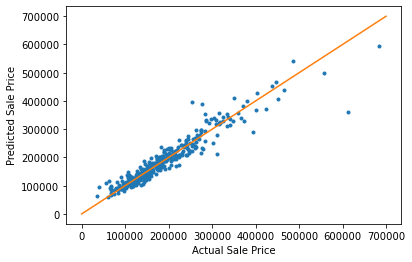

In [352]:
# plot predicted price vs actual price
plt.plot(y_test, pred, '.')

x = np.linspace(0, 700000)
y = x
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.plot(x, y)
plt.show()

In [ ]:
out_df = x_test.copy()
out_df['Actual_Target'] = y_test
out_df['Predicted_Target'] = pred
out_df.head(30)

## ElasticNet Regression

In [332]:
el_regressor = ElasticNetCV()
el_regressor.fit(x_train,y_train)

ElasticNetCV()

In [333]:
el_y_pred=el_regressor.predict(x_test)

In [334]:
print('MAPE = ', mean_absolute_percentage_error(y_test,el_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,el_y_pred),
      '\nr2_score = ', r2_score(y_test,el_y_pred))

MAPE =  17.568843049312626 
MSE =  2159322266.578675 
r2_score =  0.6825197602599833


In [335]:
from sklearn.neighbors import KNeighborsClassifier

In [336]:
classifier = KNeighborsClassifier(n_neighbors=3)

In [337]:
classifier.fit(x_train, y_train)

ValueError: Unknown label type: 'continuous'

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=3)

In [ ]:
classifier.fit(x_train, y_train)

In [ ]:
y_pred = classifier.predict(x_test)

## Kernel Ridge Regression

In [ ]:
kernelRidge = KernelRidge(alpha=0.1, degree=2, coef0=1.3)
kernelRidge_model = kernelRidge.fit(x_train,y_train)
y_pred_KRM = kernelRidge_model.predict(x_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_KRM))

print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_KRM))

print('MAPE: %.2f'
      % np.mean(np.abs((y_test - y_pred_KRM) / y_test)))  

## Gradient Boost Regression

In [ ]:
gbr = GradientBoostingRegressor(random_state=42, subsample = 0.6, max_features=10, min_samples_split=4,
                                n_estimators=3000, learning_rate = 0.01)
gradientBoosting_model = gbr.fit(x_train,y_train)
y_pred_GBR = gradientBoosting_model.predict(x_test)

print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred_GBR))


print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred_GBR))

print('MAPE: %.2f'
      % np.mean(np.abs((y_test - y_pred_GBR)) / y_test))

## Data Exploration:

## Data Visualization (CAN BE DELETED):